In [77]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime
from pandas.tseries.offsets import BDay
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


The model is to predict the T+1 close price using the last 60 days close price as input

In [92]:
#Param
stock_code='MSFT'
today = datetime.date.today()
training_data_start='2000-01-01'
training_data_end=(today-BDay(2)).strftime('%Y-%m-%d')
yesterday=(today-BDay(1)).strftime('%Y-%m-%d')
training_data_ratio=0.8 #Ratio of data to be trained by ML model

In [93]:
df=web.DataReader(stock_code, data_source='yahoo', start= training_data_start, end= training_data_end)

In [94]:
data=df.filter(['Close'])
#Covert the dataframe to numpy array
dataset=data.values
#get the number of rows (80% of all data) to train the model
training_data_len = math.ceil(len(dataset) * training_data_ratio)

In [95]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.19922056],
       [0.19012703],
       [0.19286952],
       ...,
       [0.92868366],
       [0.9248037 ],
       [0.91958435]])

In [96]:
#Create the training dataset
#Create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#Split the data into x_train and Y_train data sets
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [97]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train= np.array(x_train), np.array(y_train)

In [98]:
#Reshape the data
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(4152, 60, 1)

In [99]:
#Build LSTM Model
model= Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [100]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [101]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

4152/4152 [==============================] - 94s 23ms/step - loss: 7.8261e-05


In [102]:
#Create the new testing set
#Create a new array containing scaled value from 
test_data= scaled_data[training_data_len-60: , :]
#Create the data sets x_test and y_test
x_test=[]
y_test= dataset[training_data_len:, :]
for i in range (60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [103]:
#Conver the data to a numpy array
x_test = np.array(x_test)

In [104]:
#Reshape the data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [105]:
#Get the models predicted price value
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [106]:
#Get the root mean squared error 

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

7.123254803071166

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show>

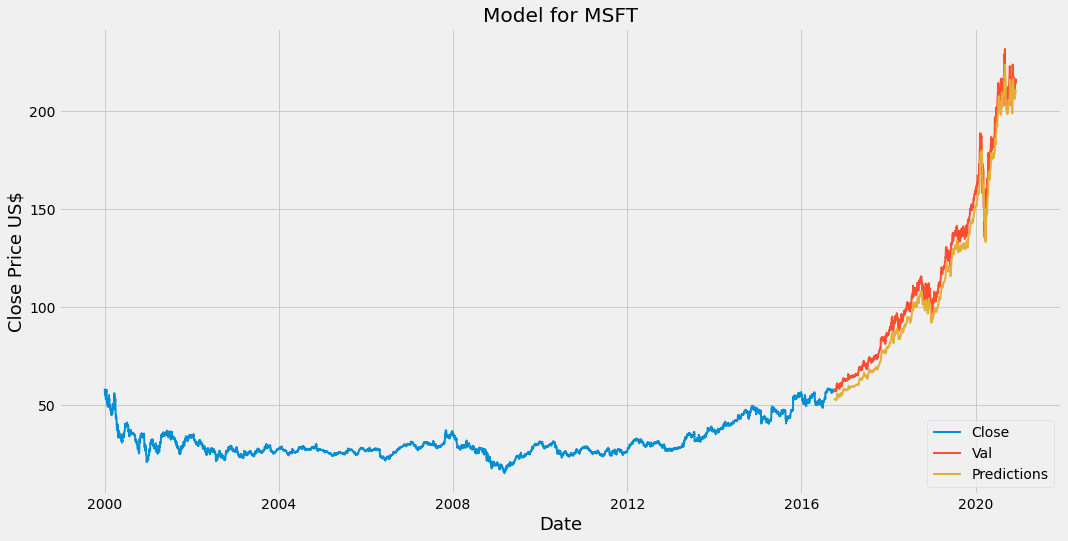

In [107]:
#Plot the training result
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions']= predictions
#Visualize the training result
plt.figure(figsize=(16,8))
plt.title('Model for {}'.format(stock_code))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price US$', fontsize=18)
plt.plot(train['Close'],linewidth=2)
plt.plot(valid[['Close','Predictions']], linewidth=2)
plt.legend(['Close','Val','Predictions'], loc='lower right')
plt.show